
このノートブックを実行するには、次の追加ライブラリが必要です。 Colab での実行は実験的なものであることに注意してください。問題がある場合は、Github の問題を報告してください。


In [ ]:
!pip install d2l==1.0.0-beta0



# ガウス過程事前分布

ガウス過程 (GP) を理解することは、モデルの構築と一般化について推論し、アクティブ ラーニングやディープ ラーニングのハイパーパラメーター調整などのさまざまなアプリケーションで最先端のパフォーマンスを達成するために重要です。 GP はどこにでもありますが、GP が何であり、どのように使用できるかを知ることは私たちの関心になります。

このセクションでは、関数に対するガウス過程*事前確率*を紹介します。次のノートブックでは、これらの事前分布を使用して*事後推論*を行い、予測を行う方法を示します。次のセクションは「GP の概要」として見ることができ、実際にガウス プロセスを適用するために必要なものを簡単に説明します。


In [1]:
import numpy as np
from scipy.spatial import distance_matrix
from d2l import torch as d2l

d2l.set_figsize()


## 意味

ガウス プロセスは*、有限数のランダム変数の集合として定義され、結合ガウス分布を持ちます*。関数 $f(x)$ が*平均関数*$m(x)$ と*共分散関数*または*カーネル*$k(x,x&#39;)$ を備えたガウス過程である場合、$f(x) \sim \mathcal{GP} (m, k)$ の場合、入力点 $x$ (時間、空間位置、画像ピクセルなど) の集合でクエリされた関数値の集合は、平均ベクトル $\mu$ を持つ結合多変量ガウス分布を持ちます。共分散行列 $K$: $f(x_1),\dots,f(x_n) \sim \mathcal{N}(\mu, K)$、ここで $\mu_i = E[f(x_i)] = m(x_i )$ および $K_{ij} = \mathrm{Cov}(f(x_i),f(x_j)) = k(x_i,x_j)$。

この定義は抽象的で理解しにくいように思えるかもしれませんが、ガウス過程は実際には非常に単純なオブジェクトです。任意の機能

$$f(x) = w^{\top} \phi(x) = \langle w, \phi(x) \rangle,$$ :eqlabel: `eq_gp-function`

 $w$ はガウス (正規) 分布から抽出され、$\phi$ は基底関数の任意のベクトルです (例: $\phi(x) = (1, x, x^2, ..., x^d) )^{\top}$ はガウス過程です。さらに、任意のガウス過程 f(x) は方程式 :eqref: `eq_gp-function`の形式で表現できます。ガウス プロセスについて学び始めるために、いくつかの具体的な例を考えてみましょう。その後、ガウス プロセスが実際にいかにシンプルで有用であるかを理解できるようになります。

## 単純なガウスプロセス

$f(x) = w_0 + w_1 x$ および $w_0, w_1 \sim \mathcal{N}(0,1)$ で、$w_0、w_1、x$ がすべて 1 次元であると仮定します。この関数は内積 $f(x) = (w_0, w_1)(1, x)^{\top}$ として等価的に書くことができます。上記の :eqref: `eq_gp-function`では、$w = (w_0, w_1)^{\top}$ および $\phi(x) = (1,x)^{\top}$ です。

任意の $x$ について、$f(x)$ は 2 つのガウス確率変数の合計です。ガウス分布は加算の下で閉じられるため、$f(x)$ は任意の $x$ に対するガウス確率変数でもあります。実際、特定の $x$ について、$f(x)$ が $\mathcal{N}(0,1+x^2)$ であることを計算できます。同様に、関数値の任意の集合 $(f(x_1),¥dots,f(x_n))$ と入力 $x_1,¥dots,x_n$ の集合の同時分布は、多変量ガウス分布です。したがって、$f(x)$ はガウス過程です。

つまり、$f(x)$ は*ランダム関数*、または*関数上の分布*です。 $w_0、w_1$ の値を繰り返しサンプリングし、次のように傾きと異なる切片を持つ直線である対応する関数 $f(x)$ を視覚化することで、この分布についてある程度の洞察を得ることができます。


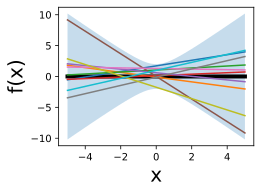

In [2]:
def lin_func(x, n_sample):
    preds = np.zeros((n_sample, x.shape[0]))
    for ii in range(n_sample):
        w = np.random.normal(0, 1, 2)
        y = w[0] + w[1] * x
        preds[ii, :] = y
    return preds

x_points = np.linspace(-5, 5, 50)
outs = lin_func(x_points, 10)
lw_bd = -2 * np.sqrt((1 + x_points ** 2))
up_bd = 2 * np.sqrt((1 + x_points ** 2))

d2l.plt.fill_between(x_points, lw_bd, up_bd, alpha=0.25)
d2l.plt.plot(x_points, np.zeros(len(x_points)), linewidth=4, color='black')
d2l.plt.plot(x_points, outs.T)
d2l.plt.xlabel("x", fontsize=20)
d2l.plt.ylabel("f(x)", fontsize=20)
d2l.plt.show()


$w_0$ と $w_1$ が $\mathcal{N}(0,\alpha^2)$ から引き出された場合、$\alpha$ の変化が関数全体の分布にどのような影響を与えると想像できますか?

## 重量空間から関数空間へ

上のプロットでは、モデル内のパラメーターの分布がどのように関数の分布を引き起こすかを示しました。モデル化したい関数については、滑らか、周期的、急速に変化するなどのアイデアがあることがよくありますが、ほとんど解釈できないパラメータについて推論するのは比較的面倒です。幸いなことに、ガウス プロセスは、関数について*直接*推論するための簡単なメカニズムを提供します。ガウス分布は最初の 2 つのモーメント、平均行列と共分散行列によって完全に定義されるため、拡張によるガウス過程は平均関数と共分散関数によって定義されます。

上の例では、平均関数は

$$m(x) = E[f(x)] = E[w_0 + w_1x] = E[w_0] + E[w_1]x = 0+0 = 0.$$

同様に、共分散関数は次のようになります。

 $$k(x,x&#39;) = \mathrm{Cov}(f(x),f(x&#39;)) = E[f(x)f(x&#39;)]-E[f(x)]E[ f(x&#39;)] = E[w_0^2 + w_0w_1x&#39; + w_1w_0x + w_1^2xx&#39;] = 1 + xx&#39;.$$

パラメータ上の分布からサンプリングする必要がなく、関数上の分布を直接指定してサンプリングできるようになりました。たとえば、$f(x)$ から描画するには、クエリしたい $x$ のコレクションに関連付けられた多変量ガウス分布を単純に形成し、そこから直接サンプリングすることができます。この定式化がどれほど有利であるかが分かるようになるでしょう。

まず、上記の単純な直線モデルに対する本質的に同じ導出が、 $f(x) = w^{\top} \phi(x)$*という形式*のモデルの平均と共分散関数を見つけるために適用できることに注意してください。 , $w \sim \mathcal{N}(u,S)$ です。この場合、平均関数 $m(x) = u^{\top}\phi(x)$ と共分散関数 $k(x,x&#39;) = \phi(x)^{\top}S \ファイ(x&#39;)$。 $\phi(x)$ は任意の非線形基底関数のベクトルを表すことができるため、*無限の*数のパラメーターを持つモデルを含む、非常に一般的なモデル クラスを検討しています。

## 放射基底関数 (RBF) カーネル

*動径基底関数*(RBF) カーネルは、ガウス プロセスおよびカーネル マシン一般で最も一般的な共分散関数です。このカーネルの形式は $k_{\text{RBF}}(x,x&#39;) = a^2\exp\left(-\frac{1}{2\ell^2}||x-x&#39;|| ^2\right)$、ここで $a$ は振幅パラメータ、$\ell$ は*長さスケールの*ハイパーパラメータです。

重み空間から始めてこのカーネルを導出してみましょう。機能を考えてみる

$$f(x) = \sum_{i=1}^J w_i \phi_i(x), w_i \sim \mathcal{N}\left(0,\frac{\sigma^2}{J}\right) , \phi_i(x) = \exp\left(-\frac{(x-c_i)^2}{2\ell^2 }\right).$$

 $f(x)$ は、次の図に示すように、点 $c_i$ を中心とした幅 $\ell$ の動径基底関数の合計です。

 $f(x)$ は、$w^{\top} \phi(x)$ という形式を持つものとして認識できます。ここで、$w = (w_1,\dots,w_J)^{\top}$ および $\phi( x)$ は、各動径基底関数を含むベクトルです。このガウス過程の共分散関数は次のようになります。

 $$k(x,x&#39;) = \frac{\sigma^2}{J} \sum_{i=1}^{J} \phi_i(x)\phi_i(x&#39;).$$

ここで、パラメーター (および基底関数) の数を無限大にすると何が起こるかを考えてみましょう。 $c_J = \log J$、$c_1 = -\log J$、$c_{i+1}-c_{i} = \Delta c = 2\frac{\log J}{J}$ とすると、 $J \to \infty$。共分散関数はリーマン和になります。

 $$k(x,x&#39;) = \lim_{J \to \infty} \frac{\sigma^2}{J} \sum_{i=1}^{J} \phi_i(x)\phi_i(x &#39;) = \int_{c_0}^{c_\infty} \phi_c(x)\phi_c(x&#39;) dc.$$

 $c_0 = -\infty$ および $c_\infty = \infty$ を設定することにより、無限に多くの基底関数を実数直線全体に広げ、それぞれの距離は $\Delta c \to 0$ になります。

 $$k(x,x&#39;) = \int_{-\infty}^{\infty} \exp(-\frac{(xc)^2}{2\ell^2}) \exp(-\frac{ (x&#39;-c)^2}{2\ell^2 }) dc = \sqrt{\pi}\ell \sigma^2 \exp(-\frac{(x-x&#39;)^2}{2( \sqrt{2} \ell)^2}) \propto k_{\text{RBF}}(x,x&#39;).$$

ここで私たちが行ったことを理解するために少し時間を取る価値があります。関数空間表現に移行することで、有限量の計算を使用して、*無限の*数のパラメーターを持つモデルを表現する方法を導き出しました。 RBF カーネルを使用したガウス プロセスは*汎用近似器*であり、任意の連続関数を任意の精度で表現できます。上記の導出から、その理由が直感的にわかります。各動径基底関数を $\ell \to 0$ を取る点質量に折りたたんで、各点質量に希望の高さを与えることができます。

したがって、RBF カーネルを使用したガウス プロセスは、無限の数のパラメーターを備え、有限のニューラル ネットワークよりもはるかに高い柔軟性を備えたモデルです。おそらく、*オーバーパラメータ化された*ニューラル ネットワークに関する大騒ぎはすべて見当違いなのかもしれません。これから説明するように、RBF カーネルを備えた GP は過剰適合せず、実際、小さなデータセットに対して特に魅力的な汎化パフォーマンスを提供します。さらに、 :cite: `zhang2021understanding`の例では、画像をランダムなラベルに完全に適合させながら、構造化された問題をうまく一般化する機能など (ガウス プロセスを使用して完全に再現できます) :cite: `wilson2020bayesian` 。ニューラル ネットワークは、私たちが考えているほど明確ではありません。

 RBF カーネルと関数上の分布から直接サンプリングすることで、 *length-scale*などのハイパーパラメーターを使用してガウス過程についてさらに直感的に構築できます。前と同様に、これには簡単な手順が含まれます。
1.  GP にクエリする入力 $x$ ポイントを選択します: $x_1,\dots,x_n$。
1.  $m(x_i)$、$i = 1,\dots,n$、および $k(x_i,x_j)$ を $i,j = 1,\dots,n$ に対して評価して、それぞれ平均ベクトルと共分散行列を形成します$\mu$ と $K$、ここで $(f(x_1),\dots,f(x_n)) \sim \mathcal{N}(\mu, K)$。
1. この多変量ガウス分布からサンプリングして、サンプル関数値を取得します。
1. サンプリング回数を増やすと、それらの時点でクエリされたより多くのサンプル関数が視覚化されます。

このプロセスを下の図に示します。


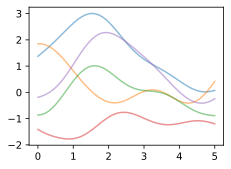

In [3]:
def rbfkernel(x1, x2, ls=4.):  #@save
    dist = distance_matrix(np.expand_dims(x1, 1), np.expand_dims(x2, 1))
    return np.exp(-(1. / ls / 2) * (dist ** 2))

x_points = np.linspace(0, 5, 50)
meanvec = np.zeros(len(x_points))
covmat = rbfkernel(x_points,x_points, 1)

prior_samples= np.random.multivariate_normal(meanvec, covmat, size=5);
d2l.plt.plot(x_points, prior_samples.T, alpha=0.5)
d2l.plt.show()


## ニューラル ネットワーク カーネル

機械学習におけるガウス過程の研究は、ニューラル ネットワークの研究がきっかけでした。ラドフォード・ニールはさらに大規模なベイジアン・ニューラル・ネットワークを追求し、最終的に 1994 年に (これは最も悪名高い NeurIPS の拒絶の 1 つであったため、その後 1996 年に出版されました)、無限の数の隠れユニットを持つそのようなネットワークが特定のカーネル関数を持つガウス過程になることを示しました:cite : `neal1996bayesian` 。この導出への関心が再浮上しており、ニューラル タンジェント カーネルのようなアイデアがニューラル ネットワークの一般化特性を調査するために使用されています :cite: `matthews2018gaussian` :cite: `novak2018bayesian` 。ニューラル ネットワーク カーネルは次のように導出できます。

 1 つの隠れ層を持つニューラル ネットワーク関数 $f(x)$ を考えてみましょう。

 $$f(x) = b + \sum_{i=1}^{J} v_i h(x; u_i).$$

 $b$ はバイアス、$v_i$ は隠れ重みから出力重み、$h$ は任意の有界隠れ単位伝達関数、$u_i$ は隠れ重みへの入力、$J$ は隠れ単位の数です。 $b$ と $v_i$ がゼロの平均と分散 $\sigma_b^2$ と $\sigma_v^2/J$ で独立しており、$u_i$ が独立した同一の分布を持つものとします。次に、中心極限定理を使用して、関数値 $f(x_1),\dots,f(x_n)$ の集合が同時多変量ガウス分布を持つことを示すことができます。

対応するガウス過程の平均関数と共分散関数は次のとおりです。

 $$m(x) = E[f(x)] = 0$$

 $$k(x,x&#39;) = \text{cov}[f(x),f(x&#39;)] = E[f(x)f(x&#39;)] = \sigma_b^2 + \frac{1 }{J} \sum_{i=1}^{J} \sigma_v^2 E[h_i(x; u_i)h_i(x&#39;; u_i)]$$

場合によっては、基本的にこの共分散関数を閉じた形式で評価できます。 $h(x; u) = \text{erf}(u_0 + \sum_{j=1}^{P} u_j x_j)$ とします。ここで $\text{erf}(z) = \frac{2}{ \sqrt{\pi}} \int_{0}^{z} e^{-t^2} dt$、および $u \sim \mathcal{N}(0,\Sigma)$。 $k(x,x&#39;) = \frac{2}{\pi} \text{sin}(\frac{2 \tilde{x}^{\top} \Sigma \tilde{x}&#39;}{\ sqrt{(1 + 2 \tilde{x}^{\top} \Sigma \tilde{x})(1 + 2 \tilde{x}&#39;^{\top} \Sigma \tilde{x}&#39;)}} )$。

 RBF カーネルは*静止している*、つまり*変換不変で*あることを意味し、したがって $\tau = x-x&#39;$ の関数として書くことができます。直観的に言えば、定常性とは、入力空間内を移動しても、関数の高レベルの特性 (変動率など) が変化しないことを意味します。ただし、ニューラル ネットワーク カーネルは*非定常*です。以下に、このカーネルを使用したガウス プロセスのサンプル関数を示します。関数が原点付近で質的に異なっていることがわかります。

## まとめ

ベイズ推論を実行する最初のステップには、事前分布を指定することが含まれます。ガウス プロセスを使用して、関数全体の事前分布を指定できます。モデリングの伝統的な「重み空間」ビューから始めて、モデルの関数形式から始めて、そのパラメーターにわたる分布を導入することによって、関数に対する事前分布を誘導することができます。あるいは、カーネルによって制御されるプロパティを使用して、関数空間で直接事前分布を指定することもできます。関数空間アプローチには多くの利点があります。実際には無限の数のパラメーターに対応するモデルを構築できますが、使用する計算量は有限です。さらに、これらのモデルは非常に高い柔軟性を持っていますが、どのタイプの関数がアプリオリである可能性が高いかについて強力な仮定を立てているため、小さなデータセットでも比較的良好な一般化が可能です。

関数空間におけるモデルの仮定は、カーネルによって直感的に制御されます。カーネルは、多くの場合、滑らかさや周期性など、関数のより高いレベルのプロパティをエンコードします。多くのカーネルは静止しています。これは、カーネルが翻訳不変であることを意味します。定常カーネルを使用したガウス プロセスから引き出された関数は、入力空間のどこを見ても、ほぼ同じ高レベルの特性 (変動率など) を持ちます。

ガウス プロセスは比較的一般的なモデル クラスであり、パラメーターに対するガウス プリアがある限り、多項式、フーリエ級数など、すでによく知っているモデルの例が多数含まれています。また、パラメータ全体のガウス分布がなくても、無限の数のパラメータを持つニューラル ネットワークも含まれます。ラドフォード ニールによって発見されたこの関連性は、機械学習の研究者がニューラル ネットワークから離れ、ガウス プロセスに移行するきっかけとなりました。

## 演習
1. Ornstein-Uhlenbeck (OU) カーネルを使用して GP からサンプル事前関数を描画します。 $k_{\text{OU}}(x,x&#39;) = \exp\left(-\frac{1}{2\ell}| |x - x&#39;|\right)$。長さスケール $\ell$ を同じになるように修正した場合、これらの関数は、RBF カーネルを備えた GP のサンプル関数とどのように異なって見えるでしょうか?
1.  RBF カーネルの*振幅*$a^2$ を変更すると、関数全体の分布にどのような影響が出ますか?
1.  $u(x) = f(x) + 2g(x)$ を形成するとします。ここで $f(x) \sim \mathcal{GP}(m_1,k_1)$ と $g(x) \sim \mathcal{ GP}(m_2,k_2)$。 $u(x)$ はガウス過程ですか?そうであれば、その平均関数と共分散関数は何ですか?
1.  $g(x) = a(x)f(x)$ を形成するとします。ここで、$f(x) \sim \mathcal{GP}(0,k)$ および $a(x) = x^2$ です。 $g(x)$ はガウス過程ですか?そうであれば、その平均関数と共分散関数は何ですか? $a(x)$ の効果は何ですか? $g(x)$ から抽出されたサンプル関数はどのようなものですか?
1.  $u(x) = f(x)g(x)$ を形成するとします。ここで、$f(x) \sim \mathcal{GP}(m_1,k_1)$ と $g(x) \sim \mathcal{GP }(m_2,k_2)$。 $u(x)$ はガウス過程ですか?そうであれば、その平均関数と共分散関数は何ですか?



[ディスカッション](https://discuss.d2l.ai/t/12116)
